## Module imports

In [2]:
import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt

In [3]:
import os
data_folder =os.path.join(os.getcwd(),'Datasets')
data_set = sio.loadmat(os.path.join(data_folder, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
gt = sio.loadmat(os.path.join(data_folder, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']

# Checking the shape of data_set (containing image data) and gt (containing ground truth data) Numpy arrays.
print(data_set.shape ,gt.shape)

(1217, 303, 274) (1217, 303)


In [3]:
train_fraction = 0.75
rem_classes = [0]
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)

print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 193142.
Number of test samples = 64388.


A portion of training data can optionally be set aside for validation.

In [4]:
val_fraction = 0.05
(train_rows_sub, train_cols_sub), (val_rows, val_cols) = util.val_split(
        train_rows, train_cols, gt, val_fraction=val_fraction)

KeyboardInterrupt: 

In [4]:
val_fraction = 0.05
from sklearn.model_selection import train_test_split
train_rows_sub, val_rows, train_cols_sub,val_cols = train_test_split(train_rows,train_cols, test_size=0.05, random_state=11)


In [5]:
print(len(train_rows_sub), len(val_rows), len(train_cols_sub),len(val_cols))

183484 9658 183484 9658


## Dimensionality reduction
The spectral dimension of an image dataset can be reduced using Principle Component Analysis (PCA). Although, this step is not necessary, it could significantly reduce the spectral dimension without losing important information. The 'reduce_dim' function takes the numpy array containing image data as its first argument and the number of reduced dimensions (i.e., an integer) or the minimum variance captured by PCA dimensions (i.e., a float) as the second argument.   

In [4]:
data_set = util.reduce_dim(img_data=data_set, n_components=.999)
data_set.shape


(1217, 303, 86)

Using a value of 0.999 for the percentage of captured variance, the spectral dimension was reduced from 200 to 69 bands. The new dimensions were sorted according to their contribution to the dataset variance. The top 10 dimensions of transformed data are illustrated below.

<ipython-input-7-da220c44d18f>:1: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig, axes = plt.subplots(2,5, True, True, figsize=(15,7))


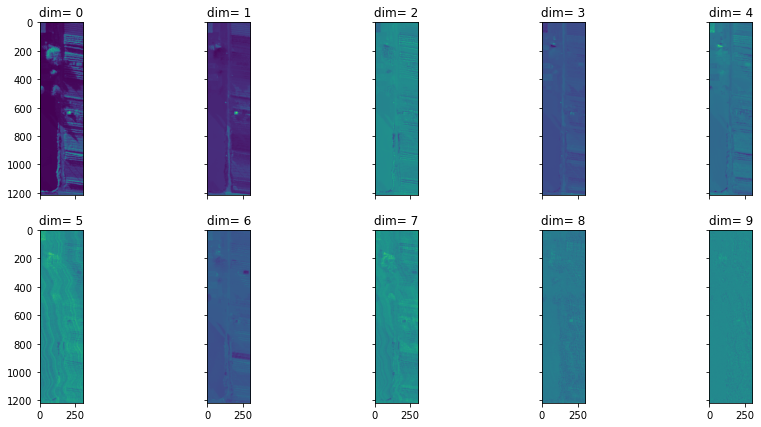

In [7]:
fig, axes = plt.subplots(2,5, True, True, figsize=(15,7))
for numb, axe in enumerate(axes.flat):
    axe.imshow(data_set[:,:,numb])
    axe.set_title('dim='+' '+str(numb))
    
fig.subplots_adjust(wspace=0, hspace=.2)
plt.show()

## Rescaling data
The 'rescale_data' function provides four methods for rescaling data at each spectral dimension. In this notebook, the 'standard' method which transforms the data to have zero mean and a standard deviation of 1 was used for rescaling data.

In [5]:
data_set = util.rescale_data(data_set)

## Creating input and target tensors
The input and target tensors should be compatible with the type of neural network model that is used for classification. The 'create_patch' function can create inputs, compatible to both pixel inputs for [MLP](deep_learning_MLP.ipynb) models as well as patch inputs for [2-D CNN](deep_learning_2D_CNN.ipynb) and [3-D CNN](deep_learning_3D_CNN.ipynb) models. 
In this notebook, a 2-D CNN model with a 'path_size' of 5 is used for classification.  

In [9]:
patch_size=9
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols) 
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels) 

train_input_sub, y_train_sub = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=train_pixel_indices_sub,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

val_input, y_val = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=val_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

test_input, y_test = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=test_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

In [6]:
int_to_vector_dict={1: [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 2: [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 3: [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 4: [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 5: [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 6: [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 7: [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 8: [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], 9: [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], 10: [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], 11: [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], 12: [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], 13: [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], 14: [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], 15: [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], 16: [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]}

## Creating a 2-D CNN model
The network architecture consists of a 2-D convolutional layer as input layer. The input layer is followed by a maximum pooling layer with a pooling and stride size of 2. The third layer is a another 2-D convolutional layer, followed by a maximum pooling layer. The fifth layer flattens the outputs of the forth layer and pass them to a 'drop out' layer with a drop rate of 0.35. The 'drop out' layer is followed by three 'dense' layers with the last one as the output layer.

In [10]:
kernel_size = 3
pool_size = 2
lr = 1e-4
l2_parm = 1e-3
batch_size = 2**3
filters_1 = 2**5
filters_2 = 2**6
units_1 = 2**9
units_2 = 2**8
drop_rate = 0.35
num_catg = len(catg_labels)
input_shape = train_input_sub.shape[1:]

# Building a 2-D CNN model
cnn_model = models.Sequential()
# conv_2D__1 (Input layer)
cnn_model.add(layer=layers.Conv2D(filters=filters_1, kernel_size=kernel_size,
                                  strides=1, padding='same',
                                  kernel_regularizer=regularizers.l2(l2_parm),
                                  input_shape=input_shape))
# max_pool_1
cnn_model.add(layer=layers.MaxPool2D(pool_size=pool_size, strides=pool_size,
                                     padding='valid'))
# conv_2_D_2
cnn_model.add(layer=layers.Conv2D(filters=filters_2, kernel_size=kernel_size,
                                  strides=1, padding='same',
                                  kernel_regularizer=regularizers.l2(l2_parm))) 
# max_pool_2
cnn_model.add(layer=layers.MaxPool2D(pool_size=pool_size, strides=pool_size,
                                     padding='valid'))
# flatten_1
cnn_model.add(layer=layers.Flatten())
# dropout_1
cnn_model.add(layer=layers.Dropout(drop_rate))
# dense_1
cnn_model.add(layer=layers.Dense(units=units_1, activation='relu'))
# dense_2
cnn_model.add(layer=layers.Dense(units=units_2, activation='relu'))
# dense_3 (output_layer)
cnn_model.add(layer=layers.Dense(units=num_catg, activation='softmax'))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 32)          24800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

## Training model and plotting training history
The model was compiled and trained using the training, validation and test [data.](#Creating-input-and-target-tensors) 

In [11]:
lr = 1e-4
batch_size = 2**5
from tensorflow.keras import optimizers
# Compiling the modele
# Compiling the model
cnn_model.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
                 loss=losses.categorical_crossentropy,
                 metrics=[metrics.categorical_accuracy])

# Training the model
history = cnn_model.fit(x=train_input_sub, y=y_train_sub, batch_size=batch_size,
                       epochs=20, validation_data=(val_input, y_val), verbose=False)
'''
# Plotting history
epoches = np.arange(1,len(history.history.get('loss'))+1)
fig, (ax1, ax2) = plt.subplots(1, 2, True, figsize=(15,7))
ax1.plot(epoches, history.history.get('loss'), 'b',label='Loss')
ax1.plot(epoches, history.history.get('val_loss'),'bo', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.legend()
ax2.plot(epoches, history.history.get('categorical_accuracy'), 'b',label='Accuracy')
ax2.plot(epoches, history.history.get('val_categorical_accuracy'),'bo', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.legend()
plt.show()
#99.99 accuracy'''

"\n# Plotting history\nepoches = np.arange(1,len(history.history.get('loss'))+1)\nfig, (ax1, ax2) = plt.subplots(1, 2, True, figsize=(15,7))\nax1.plot(epoches, history.history.get('loss'), 'b',label='Loss')\nax1.plot(epoches, history.history.get('val_loss'),'bo', label='Validation loss')\nax1.set_title('Training and validation loss')\nax1.legend()\nax2.plot(epoches, history.history.get('categorical_accuracy'), 'b',label='Accuracy')\nax2.plot(epoches, history.history.get('val_categorical_accuracy'),'bo', label='Validation accuracy')\nax2.set_title('Training and validation accuracy')\nax2.legend()\nplt.show()\n#99.99 accuracy"

In [12]:
lr = 1e-4
batch_size = 2**5
from tensorflow.keras import optimizers
# Compiling the modele
# Compiling the model
cnn_model.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
                 loss='hinge',metrics=[metrics.categorical_accuracy])

# Training the model
history = cnn_model.fit(x=train_input_sub, y=y_train_sub, batch_size=batch_size,
                       epochs=20, validation_data=(val_input, y_val), verbose=False)

KeyboardInterrupt: 

## Model performance evaluation
Overall loss and accuracy of the model was calculated using the 'evaluate' method. The loss and accuracy for each class was also calculated using the 'calc_metrics' function of the 'img_util' module.  

In [13]:
overall_loss, overal_accu = cnn_model.evaluate(test_input, y_test, verbose=False)
print('Overall loss = {}'.format(overall_loss))
print('Overall accuracy = {}\n'.format(overal_accu))

# Calculating accuracy for each class
model_metrics = util.calc_metrics(cnn_model, test_input,
                                           y_test, int_to_vector_dict, verbose=False)

#Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for key, val in model_metrics.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(key, val[0][1], 30*'_'))

Overall loss = 0.9409970045089722
Overall accuracy = 0.9987109303474426

Class ID     Accuracy
______________________________
 1            0.9987
______________________________
 2            0.9975
______________________________
 3            0.9996
______________________________
 4            0.9978
______________________________
 5            1.0000
______________________________
 6            0.9956
______________________________
 7            0.9973
______________________________
 8            0.9993
______________________________
 9            0.9987
______________________________
10            1.0000
______________________________
11            1.0000
______________________________
12            0.9967
______________________________
13            0.9925
______________________________
14            0.9987
______________________________
15            0.9824
______________________________
16            0.9997
______________________________


In [13]:
overall_loss, overal_accu = cnn_model.evaluate(test_input, y_test, verbose=False)
print('Overall loss = {}'.format(overall_loss))
print('Overall accuracy = {}\n'.format(overal_accu))

# Calculating accuracy for each class
model_metrics = util.calc_metrics(cnn_model, test_input,
                                           y_test, int_to_vector_dict, verbose=False)

#Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for key, val in model_metrics.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(key, val[0][1], 30*'_'))

Overall loss = 0.9064000248908997
Overall accuracy = 0.9218975901603699

Class ID     Accuracy
______________________________
 1            0.9987
______________________________
 2            0.0000
______________________________
 3            0.0000
______________________________
 4            0.9994
______________________________
 5            0.0000
______________________________
 6            0.9990
______________________________
 7            0.9999
______________________________
 8            0.9961
______________________________
 9            0.9450
______________________________


## Making predictions using using test data
The trained model was used for label predictions using the training, validation, and test datasets. It was also used to make label prediction for the entire dataset including unlabeled pixels. 

In [10]:
# Plotting predicted results
cnn_model
concat_rows =  np.concatenate((train_rows_sub, val_rows, test_rows))
concat_cols = np.concatenate((train_cols_sub, val_cols, test_cols))
concat_input = np.concatenate((train_input_sub, val_input, test_input))
concat_y = np.concatenate((y_train_sub, y_val, y_test))
pixel_indices = (concat_rows, concat_cols)

partial_map = util.plot_partial_map(cnn_model, gt, pixel_indices, concat_input,
                            concat_y, int_to_vector_dict, plo=False)
full_map = util.plot_full_map(cnn_model, data_set, gt, int_to_vector_dict, patch_size, plo=False)

fig, (ax1, ax2) = plt.subplots(1,2,True, True, figsize=(15,7))
ax1.imshow(partial_map)
ax1.set_title('Prediction map for labeled data', fontweight="bold", fontsize='14')
ax2.imshow(full_map)
ax2.set_title('Prediction map for all data', fontweight="bold", fontsize='14')
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vaishnavi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-022a684bbeb6>", line 5, in <module>
    concat_input = np.concatenate((train_input_sub, val_input, test_input))
  File "<__array_function__ internals>", line 5, in concatenate
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 13.4 GiB for an array with shape (257530, 9, 9, 86) and data type float64

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vaishnavi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'MemoryError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vais

TypeError: object of type 'NoneType' has no len()

In [7]:
from tensorflow import keras
cnn_model = keras.models.load_model('C:/Users/Vaishnavi/Downloads/hyperspectral-image-processing-master/hanchuan-model')

In [9]:
patch_size=5
full_map = util.plot_full_map(cnn_model, data_set, gt, int_to_vector_dict, patch_size, plo=False)
fig, (ax1, ax2) = plt.subplots(1,2,True, True, figsize=(15,7))
ax2.imshow(full_map)
ax2.set_title('Prediction map for all data', fontweight="bold", fontsize='14')
plt.show()

MemoryError: Unable to allocate 2.95 GiB for an array with shape (368751, 5, 5, 86) and data type float32

In [18]:
os.getcwd()

'C:\\Users\\Vaishnavi\\Downloads\\hyperspectral-image-processing-master'

In [20]:
cnn_model.save('C:/Users/Vaishnavi/Downloads/hyperspectral-image-processing-master/hanchuan-model')

INFO:tensorflow:Assets written to: C:/Users/Vaishnavi/Downloads/hyperspectral-image-processing-master/hanchuan-model\assets
